#### Experiment with:
* Max_depth
* n_estimators
* selected_objects for distance calculation.

# Sensitivity Analysis

In [1]:
import sys
sys.path.insert(0, '../data')

from notebooks.utils import init_results, ObjectsSelector, get_dataset, perform_experiment, SEED, PRECOMPUTED_DISTANCES_PATH, get_binary_distances_choice

import numpy as np
# ! If you use from risf.distance_functions import *. Then Parallel somehow doesn't work
# ! Now I see that this could be due to debugging mode xD
#from risf.distance_functions import (EuclideanDist, PortraitDivergenceDist, JaccardDist, ManhattanDist,CosineDist, IpsenMikailovDist, JaccardGraphDist
from risf.distance_functions import *
from pathlib import Path
from tqdm.auto import tqdm, trange
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

OKABE_ITO_SCALE = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
%load_ext autoreload
%autoreload 2

np.random.seed(SEED)

In [2]:
CLF = "RISF"

PRECOMPUTED_DISTANCES_PATH.mkdir(exist_ok=True)

DATASETS = {
    "graph":  ["p53"],
    "numerical": ["21_Lymphography", "36_speech", "6_cardio", "26_optdigits"],
    "categorical":  ["ad_nominal"],# "solar-flare_FvsAll-cleaned"],
    "timeseries": ["TwoLeadECG"]
}

DATA_DIRS = {
    "graph": Path("../data/graph"),
    "numerical" : Path("../data/numerical"),
    "categorical" : Path("../data/categorical"),
    "timeseries": Path("../data/timeseries")
}

Influence of number of selected_objects

In [3]:
DISTANCES = {
    "graph": [IpsenMikailovDist()],
    "numerical" : [EuclideanDist(), ManhattanDist(), CosineDist()],
    "categorical":[JaccardDist()],
    "timeseries": [EuclideanDist(), CosineDist()],
}

SELECTED_OBJ_RATIO = [0.01, 0.05, 0.10, 0.25, 0.5, 0.75, 1.0]
N_REPETITIONS = 1 # ! I wonder if this is really necessary

In [13]:
results_selected_obj = []

for data_type in (data_types := tqdm(DATASETS.keys())):
    data_types.set_description(data_type)
    for dataset_name in (dataset_names := tqdm(DATASETS[data_type])):
        dataset_names.set_description(dataset_name)
        for n_rep in range(N_REPETITIONS):
            objects_selector = ObjectsSelector()
            for obj_ratio in tqdm(SELECTED_OBJ_RATIO, desc="obj_ratio"):               
                data = get_dataset(data_type, DATA_DIRS[data_type], dataset_name)
                
                aucs = perform_experiment(data, DISTANCES[data_type], obj_ratio, {}, objects_selector)
                results = init_results(CLF, dataset_name, data_type, aucs, {"obj_ratio": obj_ratio})
                results_selected_obj.append(results)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

obj_ratio:   0%|          | 0/7 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

obj_ratio:   0%|          | 0/7 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

obj_ratio:   0%|          | 0/7 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

OSError: [WinError 1450] Insufficient system resources exist to complete the requested service

In [14]:
results_df = pd.DataFrame(results_selected_obj)

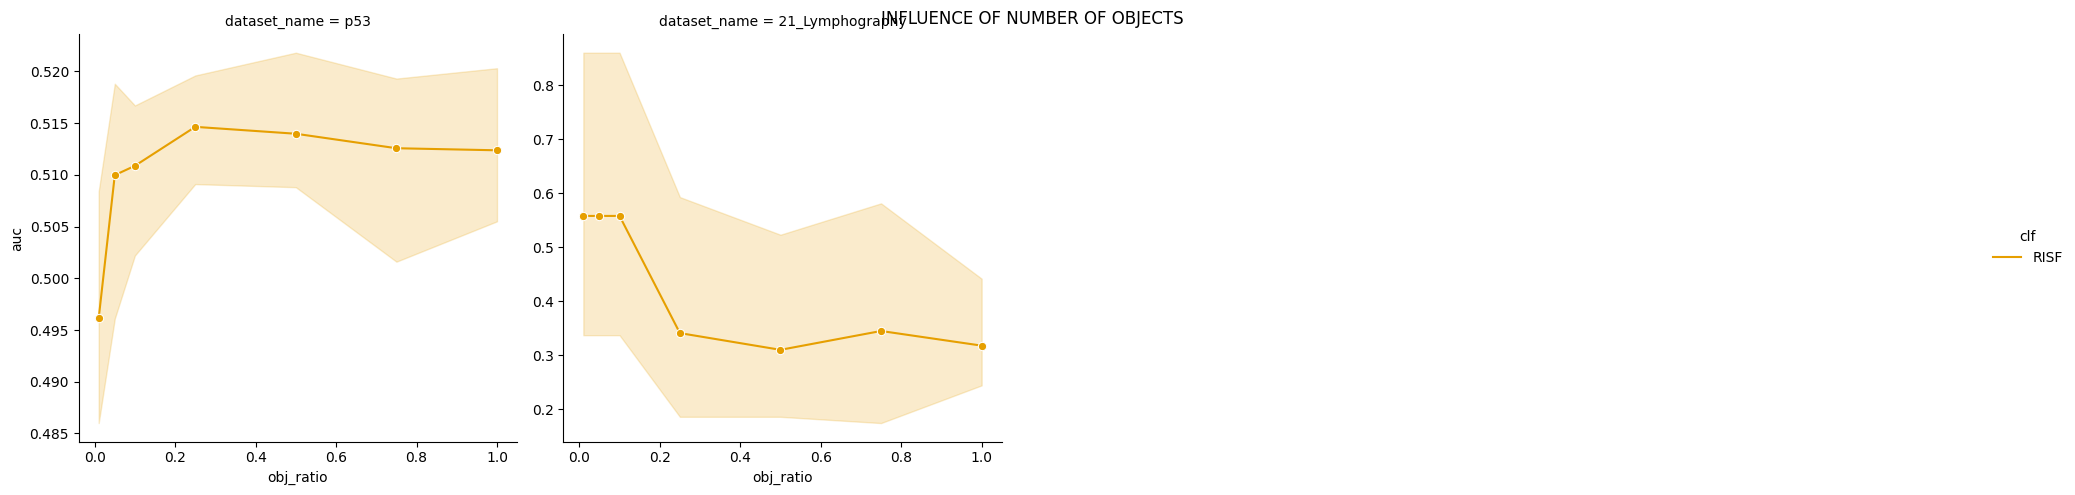

In [15]:
sns.set_palette(sns.color_palette(OKABE_ITO_SCALE))
g = sns.relplot(data=results_df, x="obj_ratio", y="auc", hue="clf", marker="o", col="dataset_name", col_wrap=4, 
            facet_kws={'sharey': False, 'sharex': False}, kind="line")

g.fig.suptitle('INFLUENCE OF NUMBER OF OBJECTS')
sns.despine()

In [5]:
OBJ_RATIO = 0.1 # Based on previous experiment

DISTANCES = {
    "graph": np.array([IpsenMikailovDist(),  PortraitDivergenceDist()], dtype=object),
    # DegreeDivergenceDist(), NetSmileDist() For now withouth these 2 guys, JaccardGraphDist(),
    "numerical" : np.array([EuclideanDist(), ManhattanDist(), CosineDist()], dtype=object),
    "categorical": np.array([JaccardDist(), DiceDist()], dtype=object),
    "timeseries": np.array([EuclideanDist(), CosineDist()], dtype=object) # For now withouthDTWDist()
}

In [13]:
results_distance_comb = []

for data_type in (data_types := tqdm(["numerical"])):#DATASETS.keys())):
    data_types.set_description(data_type)
    distances_to_use = get_binary_distances_choice(DISTANCES[data_type])
    for dataset_name in (dataset_names := tqdm(DATASETS[data_type])):
        dataset_names.set_description(dataset_name)
        for dist_to_use in tqdm(distances_to_use, desc="distances_used"):
            dist = DISTANCES[data_type][dist_to_use]
            
            data = get_dataset(data_type, DATA_DIRS[data_type], dataset_name)
            aucs = perform_experiment(CLF, data, dist, OBJ_RATIO, {})

            dist_short = '_'.join([x.__class__.__name__[:3] for x in dist])
            
            results = init_results(CLF, dataset_name, data_type, aucs, {"distances": dist_short})
            
            results_distance_comb.extend(results)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

distances_used:   0%|          | 0/7 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

distances_used:   0%|          | 0/7 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

distances_used:   0%|          | 0/7 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [15]:
results_distance_comb_df = pd.DataFrame(results_distance_comb)

c:\Users\sebas\AppData\pypoetry\virtualenvs\random-isolation-similarity-forest-bqxKmFq8-py3.10\lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


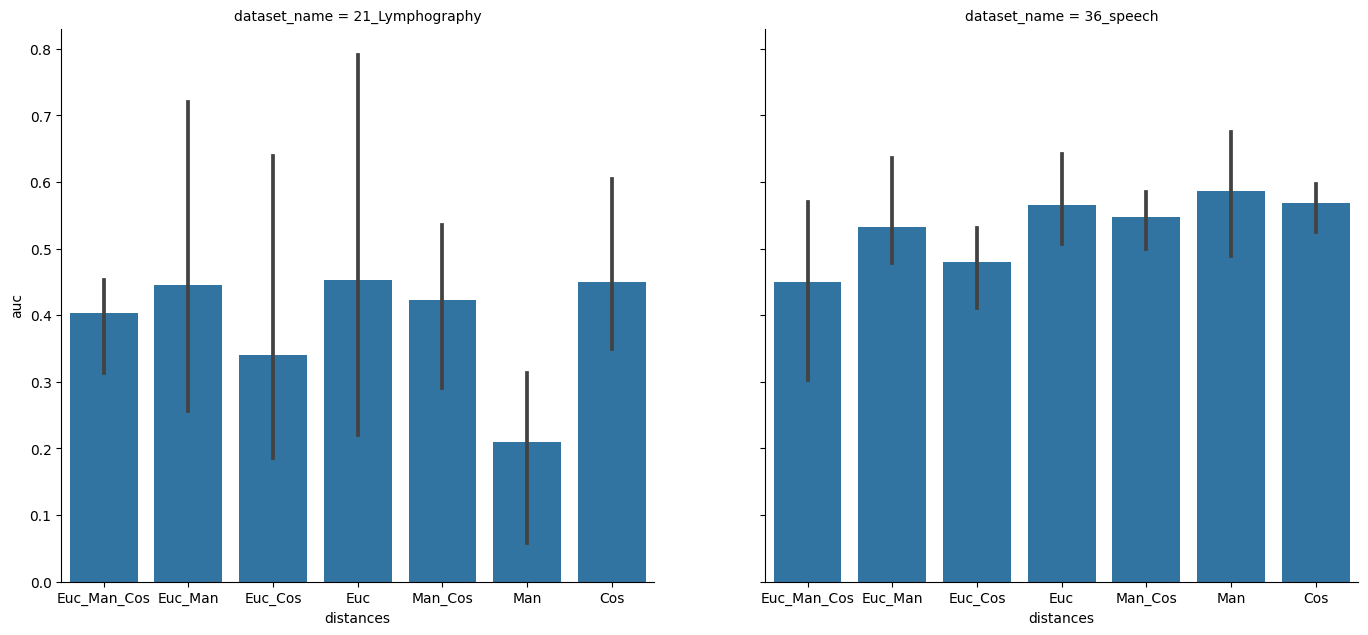

In [21]:
g = sns.FacetGrid(results_distance_comb_df, col="dataset_name")
g.map(sns.barplot,'distances', 'auc')
plt.gcf().set_size_inches(15, 8)

In [4]:
def test_one_parameter(param_name, options, distances):
    results_all = []
    for clf in ["IForest", "RISF"]:
        for data_type in (data_types := tqdm(DATASETS.keys())):
            if data_type == "graph":
                continue # Just for now as this adds another level of complexity
            data_types.set_description(data_type)
            for dataset_name in (dataset_names := tqdm(DATASETS[data_type])):
                dataset_names.set_description(dataset_name)
                for option in tqdm(options, desc=param_name):
                    clf_kwargs = {param_name: option}
                    
                    data = get_dataset(data_type, DATA_DIRS[data_type], dataset_name)
                    aucs = perform_experiment(clf, data, distances[data_type], OBJ_RATIO, clf_kwargs)

                    results = init_results(clf, dataset_name, data_type, aucs, clf_kwargs)
                    results_all.extend(results)

    pd.DataFrame(results_all).to_csv(f"results_{param_name}.csv", index=False)


In [5]:
OBJ_RATIO = 0.5 #! I wonder if this has led to such deterioration of results

DISTANCES = {
    "graph": [IpsenMikailovDist()],
    "numerical" : [EuclideanDist(), ManhattanDist(), CosineDist()],
    "categorical":[JaccardDist()],
    "timeseries": [EuclideanDist(), CosineDist()],
}

Let's see how number of trees changes the results.

In [6]:
num_of_estimators = np.array([10, 25, 50, 100, 200, 500, 750, 1000])
test_one_parameter("n_estimators", num_of_estimators, DISTANCES)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/8 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/8 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/8 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/8 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/8 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/8 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/8 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/8 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/8 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/8 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/8 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/8 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

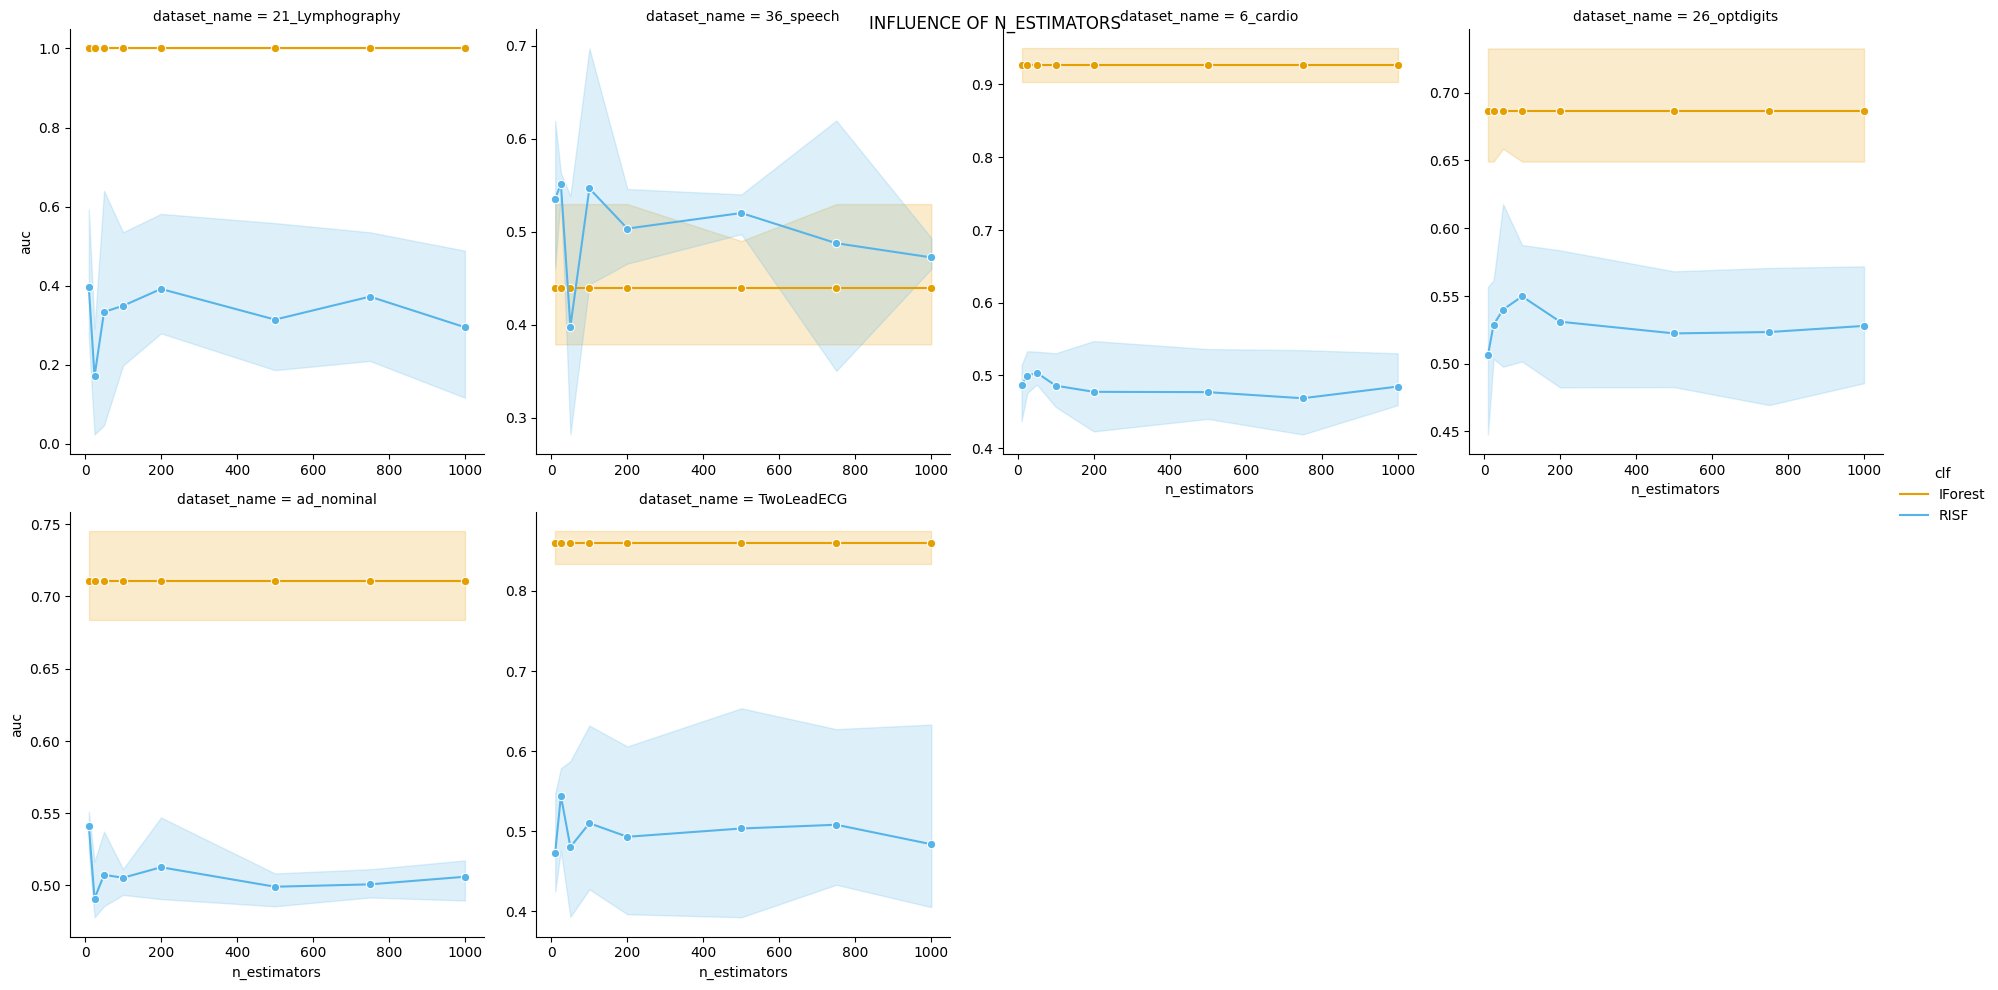

In [4]:
results = pd.read_csv("results_n_estimators.csv")

sns.set_palette(sns.color_palette(OKABE_ITO_SCALE))
g = sns.relplot(data=results, x="n_estimators", y="auc", hue="clf", marker="o", col="dataset_name", col_wrap=4, 
            facet_kws={'sharey': False, 'sharex': False}, kind="line")

g.fig.suptitle('INFLUENCE OF N_ESTIMATORS')
plt.gcf().set_size_inches(20, 10)

Let's see max_depth

In [6]:
max_depth = np.array([6,7,8,9,10])
test_one_parameter("max_depth", max_depth, DISTANCES)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

max_depth:   0%|          | 0/5 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

max_depth:   0%|          | 0/5 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

max_depth:   0%|          | 0/5 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

max_depth:   0%|          | 0/5 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

max_depth:   0%|          | 0/5 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

max_depth:   0%|          | 0/5 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

max_depth:   0%|          | 0/5 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

max_depth:   0%|          | 0/5 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

max_depth:   0%|          | 0/5 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

max_depth:   0%|          | 0/5 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

max_depth:   0%|          | 0/5 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

max_depth:   0%|          | 0/5 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

repeated holdout:   0%|          | 0/3 [00:00<?, ?it/s]

In [2]:
results = pd.read_csv("results_max_depth.csv")

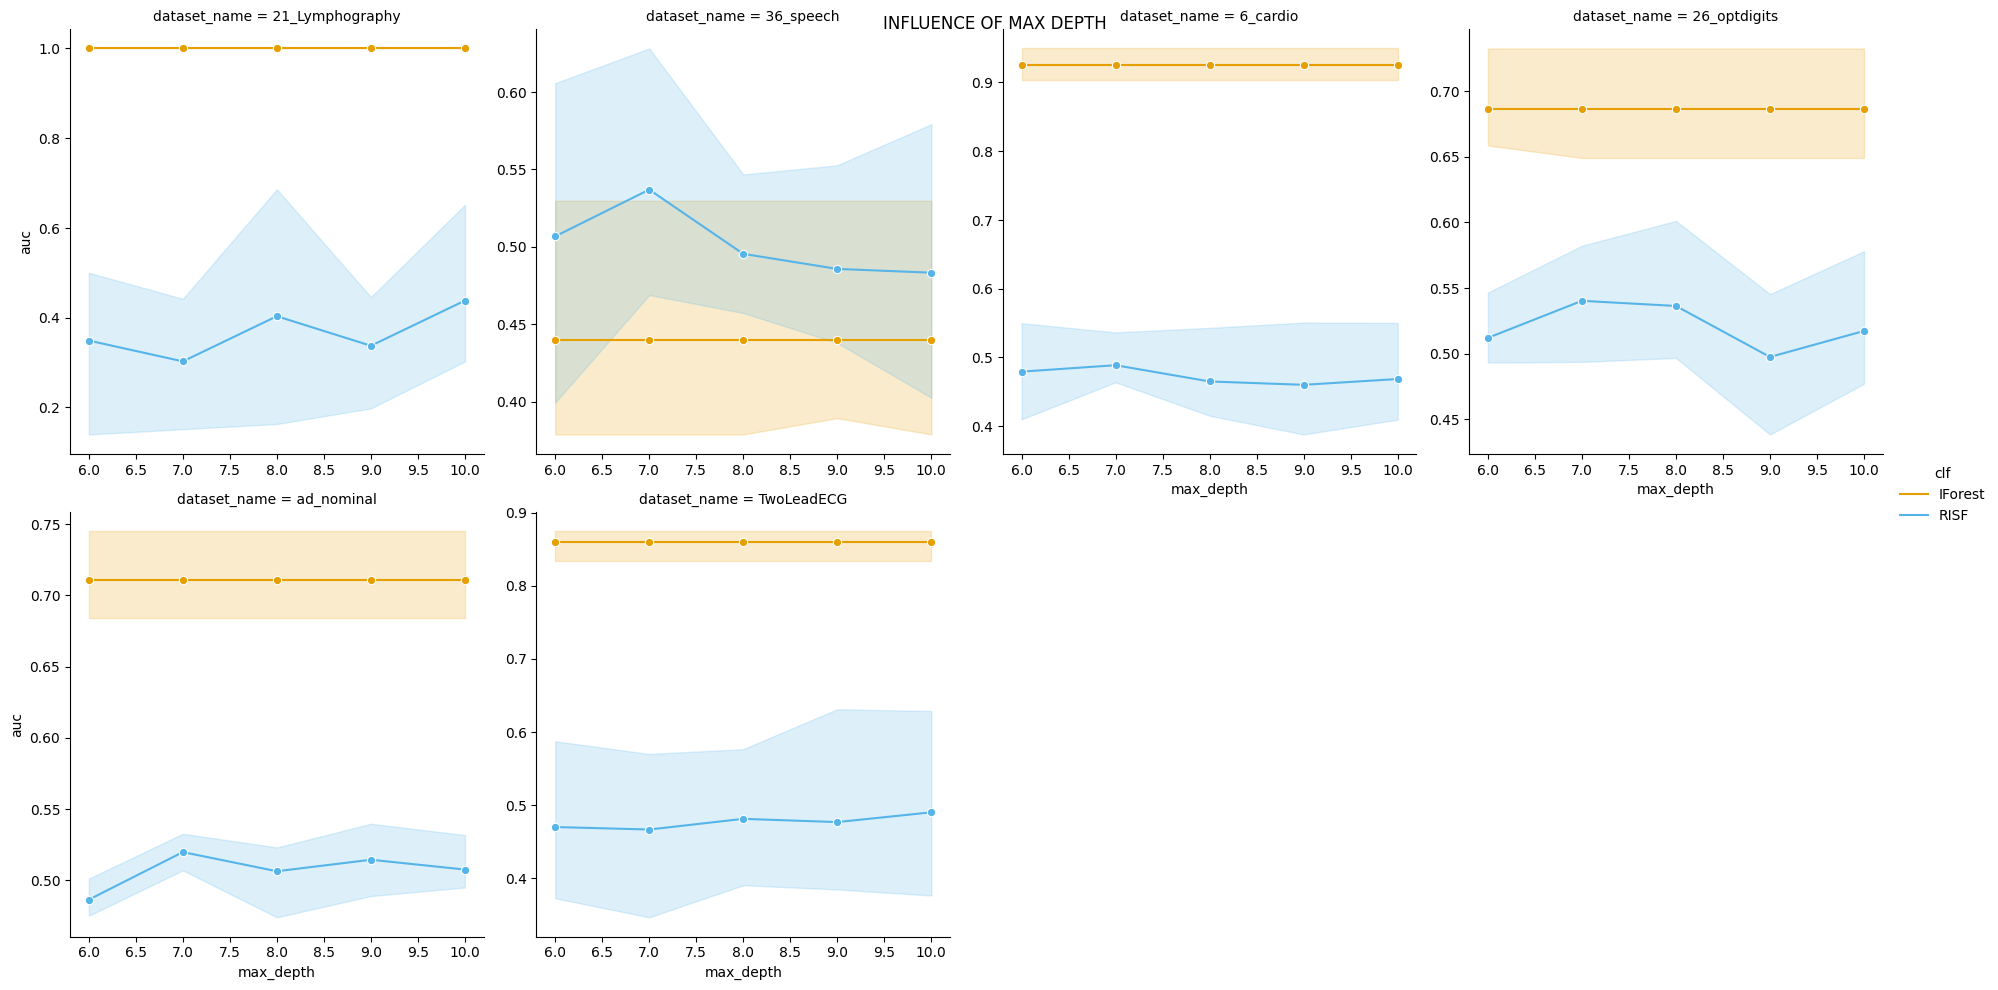

In [3]:
sns.set_palette(sns.color_palette(OKABE_ITO_SCALE))
g = sns.relplot(data=results, x="max_depth", y="auc", hue="clf", marker="o", col="dataset_name", col_wrap=4, 
            facet_kws={'sharey': False, 'sharex': False}, kind="line")

g.fig.suptitle('INFLUENCE OF MAX DEPTH')
plt.gcf().set_size_inches(20, 10)